In [ ]:
import sys
if 'google.colab' in sys.modules:
    # Instalación solo si está en Colab
    %pip install control

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.6/549.6 kB 7.9 MB/s eta 0:00:00


In [ ]:
import sys

if 'google.colab' in sys.modules:
    # Instalación solo si está en Colab
    !pip install control

In [ ]:
import sys

if 'google.colab' in sys.modules:
    # Instalación solo si está en Colab
    !pip install control

# Descripción del sistema en G(s) y discretización

In [112]:
import sympy as sp

# Inicialización
sp.init_printing()
s, z, T = sp.symbols('s z T', real=True)
Km, taum = sp.symbols('K_m tau_m', real=True, positive=True)

# Planta de tiempo continuo (un motor)
G = Km / ( s*(taum*s + 1))
print("Planta de tiempo continuo\nG(s) =")
display(G)

Planta de tiempo continuo
G(s) =


     Kₘ     
────────────
s⋅(s⋅τₘ + 1)

In [113]:
# Respuesta al escalón
Y = G/s
print("\nRespuesta al escalón\nY(s) = G(s)/s =")
display(Y)

# Expresión a la que le vamos a sacar residuos
exp = Y / (1 - sp.exp(s*T) * z**(-1))

# Buscamos los polos de G/s
den = sp.denom(Y)
p_s = sp.roots(den, s)  # Esto te da s=0 (orden 2) y s=-1/taum

# Calculamos los residuos
residuos = []
for pole, mult in p_s.items():
    res = sp.residue(exp, s, pole)
    residuos.append(res)

# Sumamos residuos
Hz = (1 - z**(-1)) * sum(residuos)

print("\nPlanta discretizada con ZOH a partir de G(s)\nH(z) =")
display(sp.simplify(Hz))



Respuesta al escalón
Y(s) = G(s)/s =


     Kₘ      
─────────────
 2           
s ⋅(s⋅τₘ + 1)


Planta discretizada con ZOH a partir de G(s)
H(z) =


   ⎛  ⎛   T     ⎞                T               ⎛   T     ⎞⎞
   ⎜  ⎜   ──    ⎟                ──              ⎜   ──    ⎟⎟
   ⎜  ⎜   τₘ    ⎟             2  τₘ              ⎜   τₘ    ⎟⎟
Kₘ⋅⎝T⋅⎝z⋅ℯ   - 1⎠ + τₘ⋅(z - 1) ⋅ℯ   - τₘ⋅(z - 1)⋅⎝z⋅ℯ   - 1⎠⎠
─────────────────────────────────────────────────────────────
                             ⎛   T     ⎞                     
                             ⎜   ──    ⎟                     
                             ⎜   τₘ    ⎟                     
                     (z - 1)⋅⎝z⋅ℯ   - 1⎠                     

# Simulación
Convertimos el sistema a una tf de python-control y luego evaluamos la respuesta al escalón comparando con la respuesta de G(s)

In [99]:
import control as ctl
import numpy as np

def sympy_to_tf(expr, z, Ts=None):
    # Extraemos los polinomios en z del numerador y el denominador
    num_sym, den_sym = sp.fraction(sp.simplify(expr))
    num_poly = sp.Poly(sp.expand(num_sym), z)
    den_poly = sp.Poly(sp.expand(den_sym), z)

    # Convierto coeficientes a array de flotantes
    num_coeffs = np.array([float(c.evalf()) for c in num_poly.all_coeffs()])
    den_coeffs = np.array([float(c.evalf()) for c in den_poly.all_coeffs()])

    # Queremos que el coeficiente del exponente más alto del denominador sea 1
    num_coeffs = num_coeffs/den_coeffs[0]
    den_coeffs = den_coeffs/den_coeffs[0]

    # Armamos el sistema en python-control. Si Ts no está definido, entonces es un sistema de tiempo continuo
    if Ts is None:
      return ctl.TransferFunction(num_coeffs, den_coeffs)
    else:
      return ctl.TransferFunction(num_coeffs, den_coeffs, Ts)


# Reemplazamos valores numéricos
Km_val = 2
taum_val = 0.5
Ts = 0.1

G_num = G.subs({Km: Km_val, taum: taum_val})
print("Planta de tiempo continuo\nG(s) =")
display(G_num)


Hz_num = Hz.subs({Km: Km_val, taum: taum_val, T: Ts})
Hz_num = sp.simplify(Hz_num)
print("\nPlanta de tiempo discreto\nH(z) =")
display(Hz_num)

# Obtengo los modelos tf de ambas plantas
tf_c = sympy_to_tf(G_num,s)
print("\nSistema continuo\n",tf_c)

tf_d = sympy_to_tf(Hz_num,z,Ts)
print("\nSistema discreto\n",tf_d)

# A fin de comparar los resultados discretizo usando la toolbox por c2d
tf_d2 = ctl.c2d(tf_c,Ts,method='zoh')
print("\nSistema discreto 2\n",tf_d2)


Planta de tiempo continuo
G(s) =


      2      
─────────────
s⋅(0.5⋅s + 1)


Planta de tiempo discreto
H(z) =


   0.022877793471864⋅z + 0.0214027581601699   
──────────────────────────────────────────────
                  2                           
1.22140275816017⋅z  - 2.22140275816017⋅z + 1.0


Sistema continuo
 <TransferFunction>: sys[113]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


    4
---------
s^2 + 2 s


Sistema discreto
 <TransferFunction>: sys[114]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


 0.01873 z + 0.01752
----------------------
z^2 - 1.819 z + 0.8187

dt = 0.1


Sistema discreto 2
 <TransferFunction>: sys[113]$sampled
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


 0.01873 z + 0.01752
----------------------
z^2 - 1.819 z + 0.8187

dt = 0.1



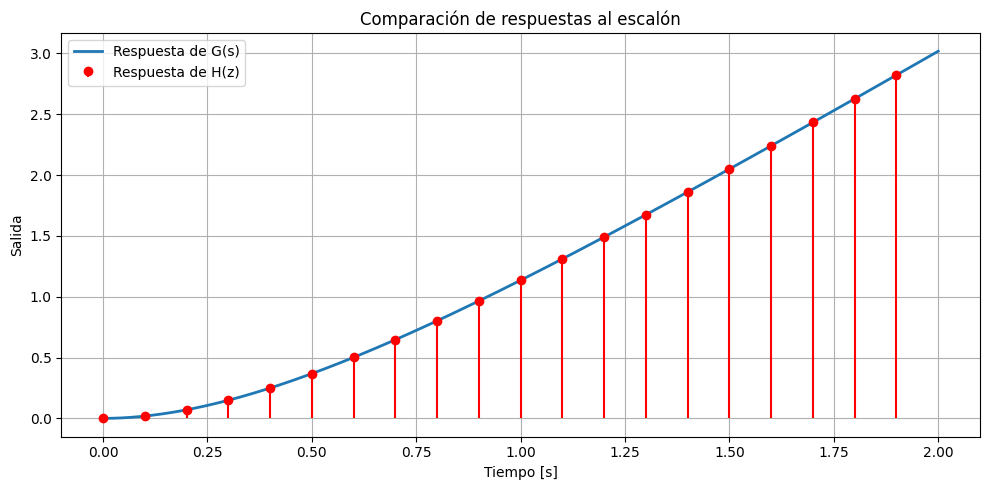

In [100]:
from matplotlib import pyplot as plt

# Tiempo de simulación
t_final = 2.0
Ts = tf_d.dt  # tiempo de muestreo

# Impulso continuo
t_cont, y_cont = ctl.step_response(tf_c, T=np.linspace(0, t_final, 1000))

# Impulso discreto
t_disc, y_disc = ctl.step_response(tf_d, T=np.arange(0, t_final, Ts))

# Graficar
plt.figure(figsize=(10,5))
plt.plot(t_cont, y_cont, label="Respuesta de G(s)", linewidth=2)
plt.stem(t_disc, y_disc, linefmt='r-', markerfmt='ro', basefmt=' ', label="Respuesta de H(z)")
#plt.step(t_disc, y_disc, 'o-', where='post', label="Respuesta escalón (discreta)")
plt.xlabel("Tiempo [s]")
plt.ylabel("Salida")
plt.title("Comparación de respuestas al escalón")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Ensayamos un control simple


Polos del sistema continuo:
[-2.+0.j  0.+0.j]


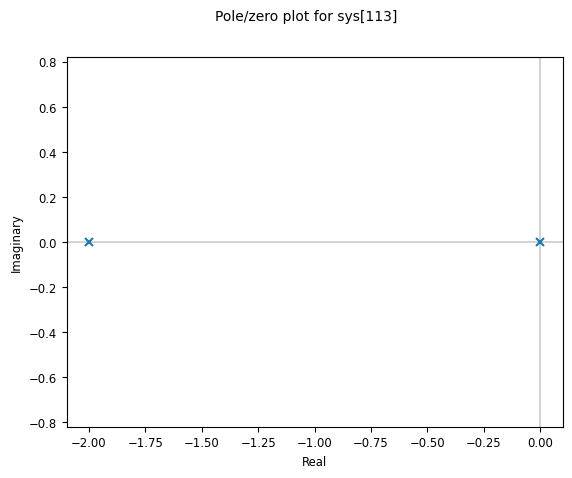

In [107]:
# Polos de G
ctl.pzmap(tf_c)
print("\nPolos del sistema continuo:")
print(tf_c.poles())



Polos del sistema discreto: [1.        +0.j 0.81873075+0.j]

Ceros del sistema discreto: [-0.93552546+0.j]

Mapeo los polos continuos:  [0.81873075+0.j 1.        +0.j]


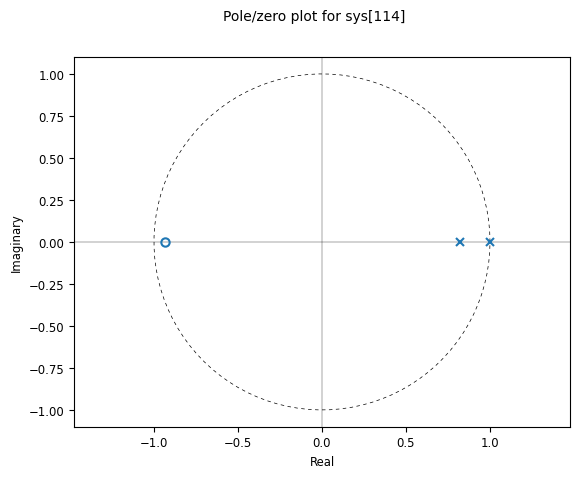

In [110]:
# Polos del sistema discreto

ctl.pzmap(tf_d)
print("\nPolos del sistema discreto:",tf_d.poles())
print("\nCeros del sistema discreto:",tf_d.zeros())

print("\nMapeo los polos continuos: ",np.exp(tf_c.poles()*tf_d.dt))



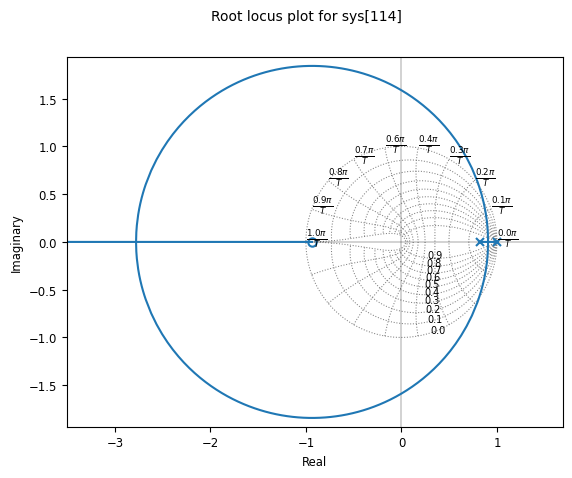

In [124]:
# Al parecer con un control proporcional aplicado al sistema discretizado podríamos obtener un sistema inestable!
ctl.rlocus(tf_d)

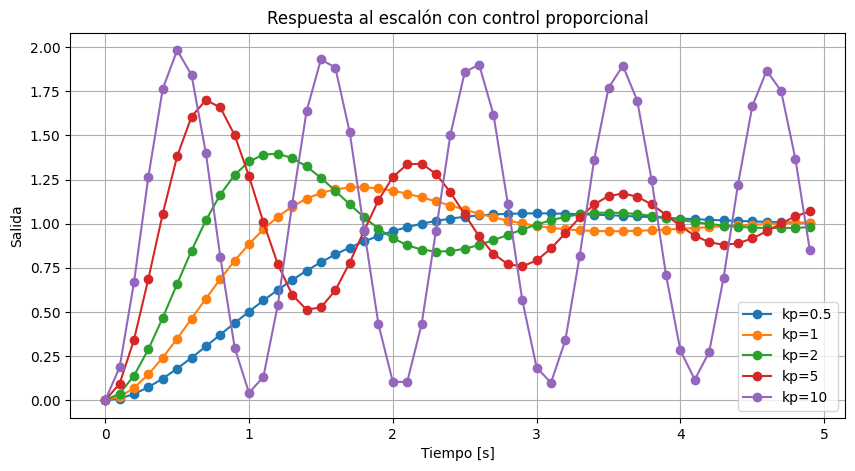

In [137]:
# Probamos un control proporcional con distintas ganancias
plt.figure(figsize=(10,5))

kp_s = [0.5,1,2,5,10]
for kp in kp_s:
  Gcl = ctl.feedback(kp*tf_d,1)
  t,y = ctl.step_response(Gcl,T=np.arange(0,5,Ts))
  plt.plot(t,y,'o-',label=f"kp={kp}")

plt.title("Respuesta al escalón con control proporcional")
plt.xlabel("Tiempo [s]")
plt.ylabel("Salida")
plt.legend()
plt.grid()
plt.show()


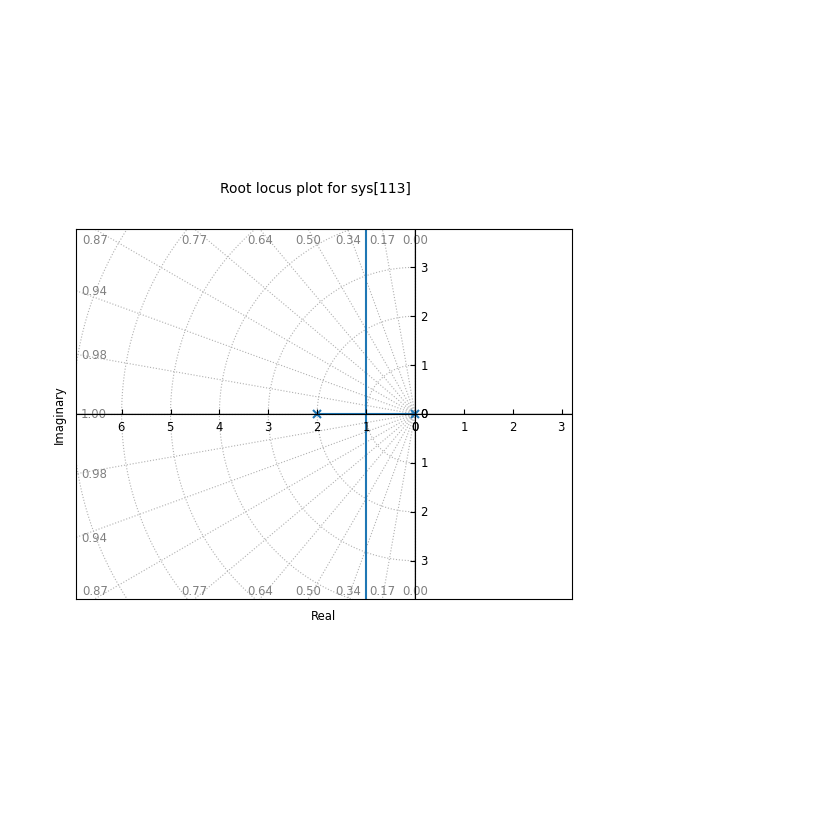

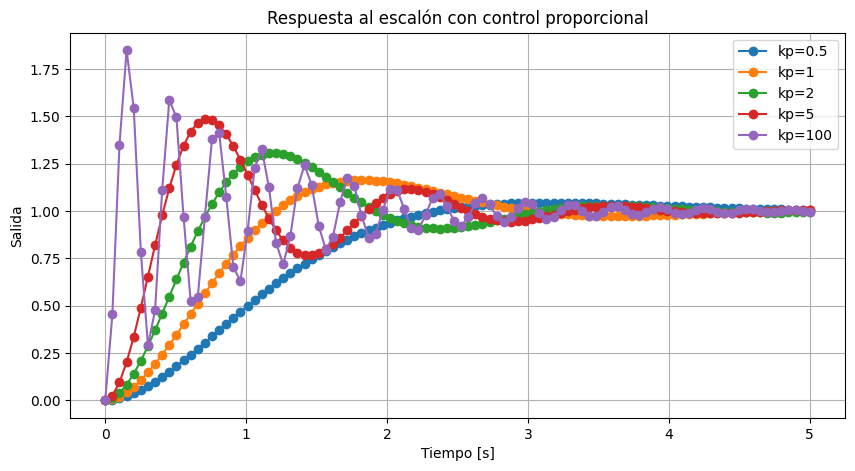

In [139]:
# En el sistema de tiempo continuo no tenemos este efecto
ctl.rlocus(tf_c)

plt.figure(figsize=(10,5))
kp_s = [0.5,1,2,5,100]
for kp in kp_s:
  Gcl = ctl.feedback(kp*tf_c,1)
  t,y = ctl.step_response(Gcl,T=np.linspace(0,5,100))
  plt.plot(t,y,'o-',label=f"kp={kp}")

plt.title("Respuesta al escalón con control proporcional")
plt.xlabel("Tiempo [s]")
plt.ylabel("Salida")
plt.legend()
plt.grid()
plt.show()